# gp2Scale via the gpOptimizer 
gp2Scale is a special setting in gpCAM that combines non-stationary, compactly-supported kernels, HPC distributed computing, and sparse random linear algebra to allow scale-up of exact GPs to millions of data points. Here we run a moderately-sized GP, just because we assume you might run this locally.

I hope it is clear how cool it is what is happening here. If you have a dask client that points to a remote cluster with 500 GPUs, you will distribute the covariance matrix computation across those. The full matrix is sparse and will be fast to work with in downstream operations. The algorithm only makes use of naturally-occuring sparsity, so the result is exact in contrast to Vecchia or inducing-point methods.

In [1]:
## First, install the newest version of gpcam
#!pip install gpcam==8.3.0


## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
from dask.distributed import Client
%load_ext autoreload
%autoreload 2

client = Client() ##this is the client you can make locally like this or 
#your HPC team can provide a script to get it. We included an example to get gp2Scale going
#on NERSC's Perlmutter


#It's good practice to make sure to wait for all the workers to be ready
client.wait_for_workers(4)

## Preparing the Data

In [3]:
def f1(x):
    return ((np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)))

input_dim = 1
N = 2001
x_data = np.random.rand(N,input_dim)
y_data = f1(x_data).flatten()

        

## Setting up the GPOptimizer with gp2Scale

In [4]:
hps_n = 2

hps_bounds = np.array([[0.01,1.],      ##signal var of Wendland kernel
                       [0.001,0.02]])  ##length scale for Wendland kernel

init_hps = np.random.uniform(size = len(hps_bounds), low = hps_bounds[:,0], high = hps_bounds[:,1])

my_gp2S = GPOptimizer(x_data,y_data,init_hyperparameters=np.array([0.73118673, 0.0013813191]), 
            gp2Scale = True, gp2Scale_batch_size= 100, gp2Scale_dask_client = client
            )

my_gp2S.train(hyperparameter_bounds=hps_bounds, max_iter = 5)


array([0.75787535, 0.00352446])

## Train gp2Scale (or any GP) via a customized block MH-MCMC

In [5]:
from gpcam import gpMCMC, ProposalDistribution

def in_bounds(v,bounds):
    if any(v<bounds[:,0]) or any(v>bounds[:,1]): return False
    return True

def prior_function(theta,args):
    bounds = args["bounds"]
    if in_bounds(theta, bounds): return 0.
    else: return -np.inf

def func(hps,args):
  result = my_gp2S.log_likelihood(hyperparameters=hps)
  return result


pd1 = ProposalDistribution([0,1], init_prop_Sigma=np.identity(2) * 0.01)
my_mcmc = gpMCMC(func, prior_function, [pd1],
          args={"bounds":hps_bounds})

mcmc_result = my_mcmc.run_mcmc(x0=np.array([1.,0.01]), info=True, n_updates=2) ##usually you would do >200 updates


Starting likelihood. f(x)=  2659.457127486179


In [6]:
my_gp2S.set_hyperparameters(mcmc_result["mean(x)"])

## Vizualizing the Result

[1.   0.01]


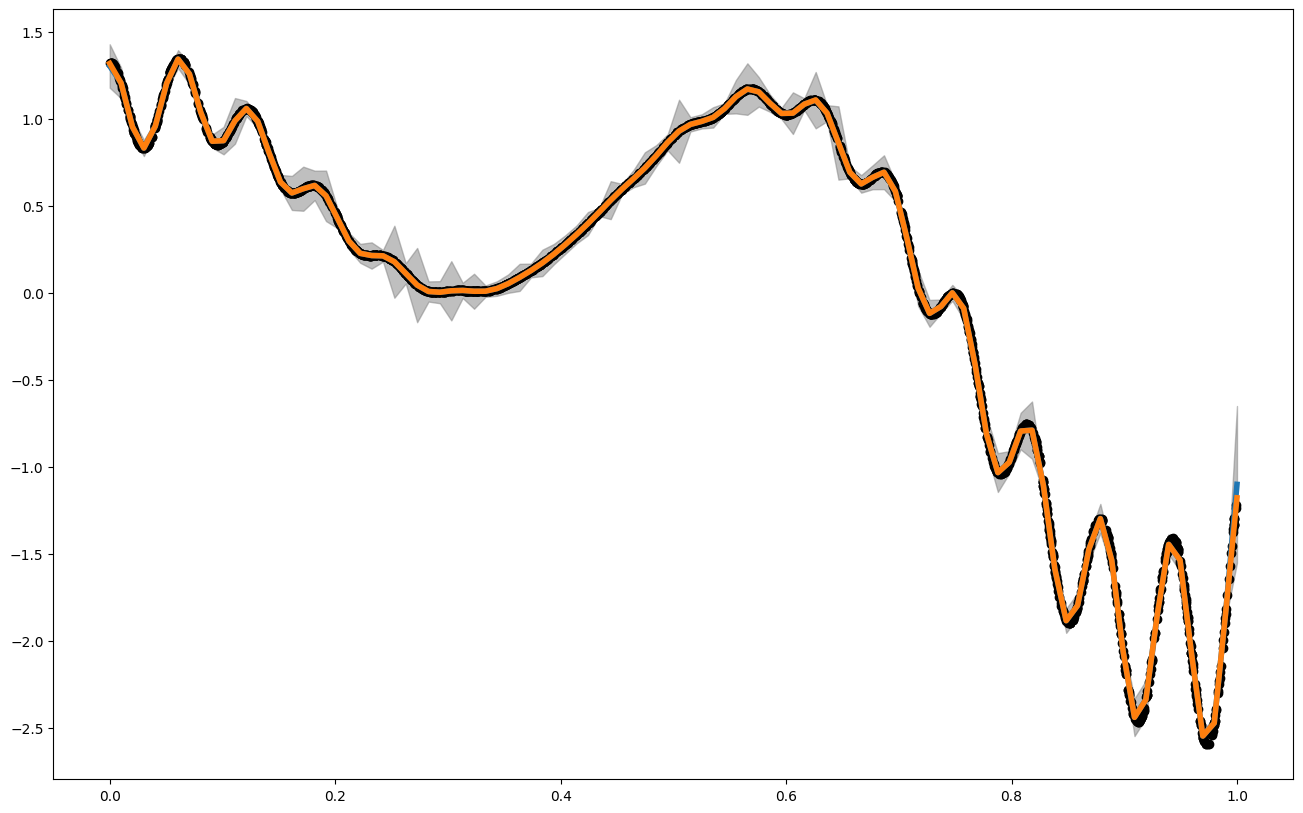

In [7]:
x_pred = np.linspace(0,1,100) ##for big GPs, this is usually not a good idea, but in 1d, we can still do it
                              ##It's better to do predictions only for a handful of points.

mean1 = my_gp2S.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp2S.posterior_covariance(x_pred.reshape(-1,1), variance_only=False)["v(x)"]

print(my_gp2S.get_hyperparameters())

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred,f1(x_pred), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')

In [8]:
#best new \in [0,1]
my_gp2S.ask(np.array([[0,1]]))

{'x': array([[0.99999672]]), 'f_a(x)': array([0.14931293]), 'opt_obj': None}

In [9]:
#bets new point in {0,.5,1}
new_ = my_gp2S.ask([np.array([0.]),np.array([0.5]),np.array([1.])])

In [10]:
my_gp2S.tell(new_["x"], f1(new_["x"]).flatten())